<a href="https://www.kaggle.com/code/brianvilnrotter/anxiety-attack-factors-symptoms-and-severity?scriptVersionId=219568758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anxiety-attack-factors-symptoms-and-severity/anxiety_attack_dataset.csv


### Intentions for this dataset
My intention for this data set is multi-fold.
* Firstly, I would like to analyze the data and see if there is a predictive label that can be gleamed from the data
* Second, my goal will be to build a predictive model using the data as a training source if a label is found
* Third, once I am happy with the predictive model I will try and sync the predictive model to my hugging face repo

# Table of Contents

* [0. Data Collection & Initial Analysis](#chapter0)

## 0. Data Collection & Initial Analysis <a class="anchor" id="chapter0"></a>

In [2]:
from sklearn.feature_selection import SelectKBest,chi2, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
df = pd.read_csv('/kaggle/input/anxiety-attack-factors-symptoms-and-severity/anxiety_attack_dataset.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,12000.0,6000.500000,3464.245950,1.0,3000.75,6000.5,9000.250,12000.0
Age,12000.0,40.966750,13.473280,18.0,29.00,41.0,53.000,64.0
Sleep Hours,12000.0,6.482650,2.014885,3.0,4.80,6.5,8.200,10.0
Physical Activity (hrs/week),12000.0,5.030892,2.889000,0.0,2.50,5.0,7.525,10.0
Caffeine Intake (mg/day),12000.0,246.696083,144.487071,0.0,122.00,244.0,371.000,499.0
Alcohol Consumption (drinks/week),12000.0,9.492833,5.769364,0.0,5.00,9.0,15.000,19.0
Stress Level (1-10),12000.0,5.462250,2.897201,1.0,3.00,5.0,8.000,10.0
Heart Rate (bpm during attack),12000.0,119.398500,34.806711,60.0,89.00,119.0,149.000,179.0
Breathing Rate (breaths/min),12000.0,25.462333,8.090686,12.0,18.00,25.0,32.000,39.0
Sweating Level (1-5),12000.0,2.987417,1.414482,1.0,2.00,3.0,4.000,5.0


In [4]:
df.head()

,ID,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm during attack),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Severity of Anxiety Attack (1-10)
0,1,56,Female,Other,9.6,8.3,175,6,No,No,4,145,33,3,No,No,4,Yes,9,10
1,2,46,Male,Teacher,6.4,7.3,97,6,No,No,3,143,18,5,Yes,No,0,No,9,8
2,3,32,Female,Doctor,6.9,1.0,467,14,No,No,2,60,34,1,No,No,7,Yes,10,5
3,4,60,Male,Doctor,9.2,3.7,471,16,No,Yes,6,94,19,1,No,Yes,4,Yes,5,8
4,5,25,Male,Student,9.2,2.5,364,2,No,Yes,7,152,15,4,No,Yes,0,No,1,1


In [5]:
def encoding_categorical_data(df):
    label_encoders = {}
    for column in df.columns:
        if not pd.api.types.is_numeric_dtype(df[column]):
            label_encoders[column] = LabelEncoder()
            df[column] = label_encoders[column].fit_transform(df[column])
    return df

def calculate_correlation_power(df):
    results = {}
    df = encoding_categorical_data(df)

    for label in df.columns:
        X = df.drop(columns=[label])
        y = df[label]
    
        if pd.api.types.is_numeric_dtype(y):
            total_power = 0
            for feature in X.columns:
                if pd.api.types.is_numeric_dtype(X[feature]):
                    corr = df[[label,feature]].corr().iloc[0,1]
                    total_power += abs(corr) if not np.isnan(corr) else 0
                else:
                    mi_score = mutual_info_regression(X[[feature]],y).item()
                    total_power += mi_score
        else:
            total_power = 0
            for feature in X.columns:
                if pd.api.types.is_numeric_dtype(X[feature]):
                    mi_score = mutual_info_classif(X[[feature]],y).item()
                    total_power += mi_score
                else:
                    contingency_table = pd.crosstab(X[feature],y)
                    chi2,p,_,_ = chi2_contingency(contingency_table)
                    total_power += chi2
        results[label] = total_power
    return results

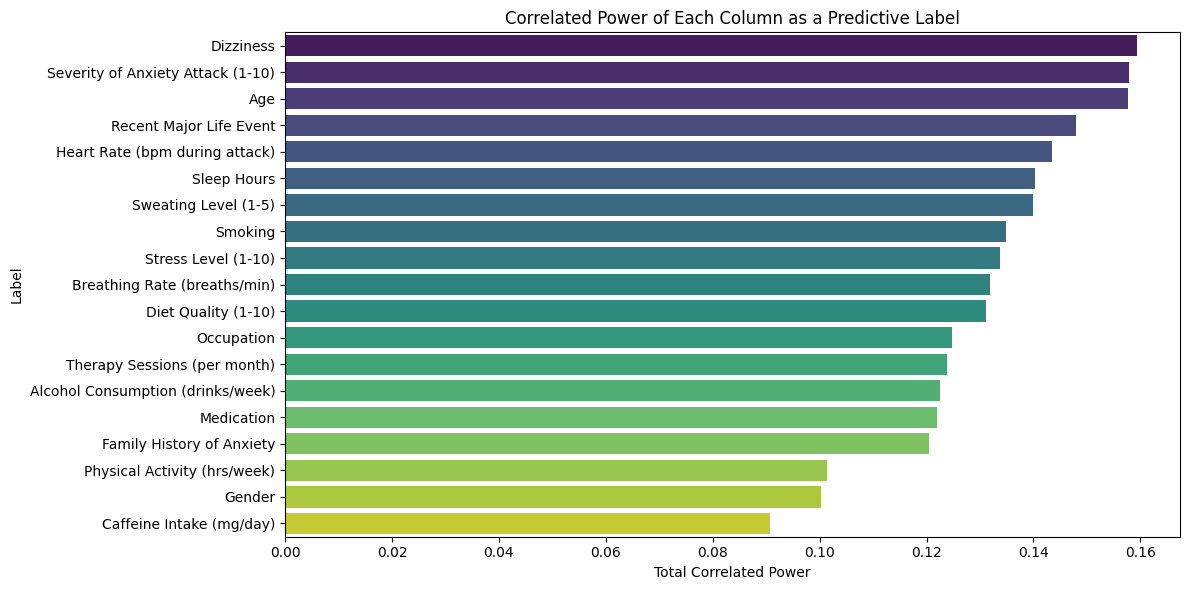

In [6]:
correlation_power = calculate_correlation_power(df.drop('ID',axis=1))

results_df = pd.DataFrame(list(correlation_power.items()),columns=['Label','Correlated Power'])
results_df = results_df.sort_values(by='Correlated Power',ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Correlated Power',y='Label',data=results_df,palette='viridis')
plt.title('Correlated Power of Each Column as a Predictive Label')
plt.xlabel('Total Correlated Power')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

The above graph shows that there is potentiality for 'Dizziness' to be a potential predictive label, but in terms of practicality it would probably be more beneficial to predict the severity of an anxiety attack for medical preparation. There is also the possibility that despite Dizziness being a crucial feature with predictive power that is dependent on a number of other features, it might be artificially pushed up in the Total Correlated Power scale. For now, it is probably better to focus on a predictive model for the Severity of attack rather than the Dizziness condition. This should be done with a regressor model at first, but a softmax classifier for multi-label classification (1-10) may be beneficial as well.